In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

path = os.path.join(path, 'EEG Data')

print("Path to dataset files:", path)

100%|██████████| 557M/557M [00:09<00:00, 63.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data


In [ ]:
!pip install scipy

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [ ]:
data_root = '/root/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/'
files = os.listdir(data_root)
len(files)

34

In [ ]:
FOCUSED_CLASS = 0
UNFOCUSED_CLASS = 1
DROWNSY_CLASS = 2

In [ ]:
columns = [
    'ED_COUNTER',    'ED_INTERPOLATED',    'ED_RAW_CQ',    'ED_AF3',    'ED_F7',
    'ED_F3',    'ED_FC5',    'ED_T7',    'ED_P7',    'ED_O1',
    'ED_O2',    'ED_P8',    'ED_T8',    'ED_FC6',    'ED_F4',
    'ED_F8',    'ED_AF4',    'ED_GYROX',    'ED_GYROY',    'ED_TIMESTAMP',
    'ED_ES_TIMESTAMP',    'ED_FUNC_ID',    'ED_FUNC_VALUE',    'ED_MARKER',    'ED_SYNC_SIGNAL'
]

def get_state(timestamp):
    if timestamp <= 10*128*60:
        return FOCUSED_CLASS
    elif timestamp > 20*128*60:
        return UNFOCUSED_CLASS
    else:
        return DROWNSY_CLASS

# Scale data
scaler = StandardScaler()

#  Function to read in the EEG data and extract the valid lead data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    hz = 128
    mat = scipy.io.loadmat(data_root + filename)
    data = mat["o"]["data"][0,0]
    eeg_df = pd.DataFrame(data, columns=columns)
    eeg_df = eeg_df.filter(['ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5',
                            'ED_T7', 'ED_P7', 'ED_O1', 'ED_O2',
                            'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4',
                            'ED_F8', 'ED_AF4'])
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1','O2','P8','T8', 'FC6','F4','F8','AF4']
    eeg_df.columns = labels
    eeg_df = pd.DataFrame(scaler.fit_transform(eeg_df), columns=eeg_df.columns)
    eeg_df.reset_index(inplace=True)
    eeg_df.rename(columns={'index': 'timestamp'}, inplace=True)

    eeg_df['state'] = eeg_df['timestamp'].apply(get_state)

    return eeg_df

In [ ]:
dataset = []
# For each file, print # minutes of data
for filename in files:
    data = get_EEG_data(data_root, filename)
    dataset.append(data)

In [ ]:
dataset[0]

,timestamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,state
0,0,4.531960,-0.895227,-1.883328,2.204479,0.727474,-1.127292,1.342399,0.845784,0.981043,-1.198803,-1.105621,1.533425,1.000651,-2.397085,0
1,1,4.037800,-0.582943,-1.353393,2.669325,0.453873,-0.649846,1.964739,1.730046,0.719121,-1.198803,-0.608943,1.533425,0.693884,-2.238505,0
2,2,3.296560,-0.604730,-1.757153,3.366593,0.180272,-0.845165,1.786928,1.308012,0.220223,-1.198803,-2.098978,1.533425,0.693884,-2.011962,0
3,3,3.790720,-0.757241,-2.287088,1.739634,0.317073,-1.322610,1.386852,0.564428,0.220223,-1.198803,-3.423454,1.733554,1.000651,-2.193196,0
4,4,4.284880,-0.757241,-2.287088,1.507211,0.453873,-1.214100,1.520211,0.865881,0.145388,-1.198803,-3.423454,1.533425,1.000651,-2.510356,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333231,333231,6.261519,0.833231,4.147836,1.507211,0.590673,-0.237507,-0.902470,-1.244290,0.931153,1.708078,4.026724,-1.068250,1.307419,1.929886,1
333232,333232,2.555321,0.913118,3.769311,-0.584593,0.590673,-0.172401,-1.013602,-0.962934,1.729390,1.708078,1.377771,-0.467864,1.307419,2.133775,1
333233,333233,0.825762,0.971217,3.668371,-0.584593,0.317073,-0.128997,-1.280319,-0.721771,2.178399,1.708078,1.212212,-0.467864,0.080349,1.612726,1
333234,333234,4.284880,1.385176,4.324481,1.972057,0.453873,0.131428,-1.035829,-0.520803,0.956098,1.708078,5.351200,-0.467864,0.693884,1.680689,1


In [ ]:
dataset[2]

,timestamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,state
0,0,-1.653825,-1.967457,-0.344259,-3.430919,-0.837313,-7.834685,-6.371426,-2.284884,-1.286379,-1.587293,-3.508376,0.317259,0.291021,-0.852405,0
1,1,-3.524573,-1.935629,-0.119606,-3.430919,-2.004037,-7.703875,-6.219277,-1.843232,-0.744795,-1.587293,-2.771911,0.526858,0.650449,-0.642300,0
2,2,-4.356016,-1.776488,-0.007280,-0.839651,-2.670737,-7.599227,-6.168561,-1.671479,-0.687786,-1.587293,-2.771911,-0.311536,-0.068407,-0.642300,0
3,3,-3.108851,-1.871973,-0.344259,-0.148646,-2.670737,-7.834685,-6.354521,-1.965913,-1.542919,-1.587293,-3.403167,-0.940331,-0.787263,-1.272614,0
4,4,-3.524573,-2.062942,-0.816029,-1.876158,-1.003988,-8.057061,-6.574291,-2.407565,-2.027495,-1.587293,-3.087539,0.107661,-0.068407,-1.512733,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345159,345159,-2.069547,-0.694331,-0.523981,1.406115,-1.504012,-1.281113,0.492183,0.634923,0.309870,-0.948569,0.173951,0.317259,-1.146690,-0.942449,1
345160,345160,-1.653825,-0.312394,-0.456585,1.060612,-2.004037,-1.307275,0.542899,0.782140,0.366879,-0.948569,-0.457305,0.107661,-1.146690,-0.762360,1
345161,345161,-2.277408,-0.376050,-0.703703,0.196856,-1.337337,-1.385761,0.475277,0.561315,0.195852,-0.948569,-0.141677,-0.730732,-1.146690,-1.302629,1
345162,345162,-2.069547,-0.885300,-0.726168,1.060612,-1.837362,-1.490409,0.323128,0.291416,0.081835,-0.948569,0.173951,-1.569126,-0.427835,-1.332643,1


In [ ]:
type(dataset), type(dataset[0])

(list, pandas.core.frame.DataFrame)

In [ ]:
def split_epochs(data, hz, epoch_length=2, step_size=0.125):
    """
    Function to segment EEG signals into epochs using a sliding window and overlap.

    :param data: EEG signals (DataFrame or NumPy array).
    :param hz: Sampling frequency of the EEG signals (Hz).
    :param epoch_length: Length of each epoch (seconds).
    :param step_size: Step size between windows (seconds).

    :return: List of epochs.
    """

    step = int(epoch_length * hz - step_size * hz)
    offset = int(epoch_length * hz)
    starts = []
    current = 0

    # Generate the first series
    while current + offset <= data.shape[0]:
        starts.append(current)
        current += step

    # Generate the second series using a list comprehension
    ends = [x + offset for x in starts]

    # Lưu trữ các epoch
    epochs = []

    # Cắt các epoch từ tín hiệu
    for i in range(len(starts)):
        epoch = data.iloc[starts[i]:ends[i]]
        epochs.append(epoch)
    return epochs

In [ ]:
epochs_data = []
for eeg in dataset:
    epochs = split_epochs(eeg, 128)
    for epoch in epochs:  # Iterate directly over the epochs
        epochs_data.append(epoch)  # Append each DataFrame to the list

In [ ]:
len(epochs_data[0])

256

In [ ]:
len(epochs_data), type(epochs_data), type(epochs_data[0])

(52118, list, pandas.core.frame.DataFrame)

In [ ]:
epochs_data[604]

,timestamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,state
144960,144960,-0.162558,-0.067310,-0.672048,0.112675,-0.093329,0.326746,0.653380,0.725203,-0.129006,-0.714323,0.384414,-0.667992,-1.760255,-1.105790,2
144961,144961,0.084522,-0.118147,-0.697283,0.112675,-1.050932,0.174832,0.764512,0.685009,-0.091588,-0.714323,0.384414,-0.667992,1.614186,-1.060481,2
144962,144962,-0.903797,-0.096360,-0.444933,-0.352170,-1.461333,0.370151,0.786739,0.664913,-0.041698,-0.714323,0.384414,-0.667992,1.307419,-0.969864,2
144963,144963,-1.892117,-0.067310,-0.369228,-1.281861,0.043472,0.326746,0.742286,0.524235,-0.029226,-0.714323,0.053295,-0.868121,0.387117,-0.924555,2
144964,144964,-0.656717,-0.060048,-0.470168,-0.584593,0.727474,0.022918,0.675606,0.484041,-0.041698,-0.714323,-0.112264,-0.868121,1.920953,-0.992518,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145211,145211,-0.409637,-0.139934,-0.974868,-0.817016,0.317073,-1.062185,-1.213640,-1.244290,-0.390927,-0.714323,-0.608943,0.933038,1.000651,-0.947210,2
145212,145212,-0.656717,-0.110885,-0.798223,-0.817016,-0.230129,-0.845165,-0.813564,-1.143805,-0.278675,-0.714323,0.053295,0.933038,-2.067022,-0.879247,2
145213,145213,0.084522,-0.030998,-0.545873,0.809943,0.453873,-0.389422,-0.502394,-0.983030,-0.016753,-0.714323,0.881093,0.933038,-2.067022,-0.448815,2
145214,145214,-0.162558,0.048889,-0.116878,-0.352170,0.043472,-0.172401,-0.413489,-0.802159,0.033136,-0.714323,0.218855,0.933038,0.387117,-0.131655,2


In [ ]:
class EEGDataset(Dataset):
    def __init__(self, dataframes, target_column='state', wavelet='db6', level=4):
        """
        Args:
            dataframes (list of pd.DataFrame): List of dataframes containing EEG data.
            target_column (str): Name of the target column. Default is 'state'.
            wavelet (str): Wavelet type for processing alpha band.
            level (int): Decomposition level for the wavelet.
        """
        self.data = []
        self.targets = []
        self.scaler = StandardScaler()

        print(f"Processing {len(dataframes)} dataframes...")

        for df in dataframes:
            # Extract target
            self.targets.append(df[target_column].mode()[0])

            # Process features
            feature = df.drop(columns=[target_column, 'timestamp'], errors='ignore')
            self.data.append(feature.values)

        # Convert lists to tensors
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)  # Should match the number of targets, not individual rows

    def __getitem__(self, idx): 
        return self.data[idx], self.targets[idx]

# Create dataset
dataset = EEGDataset(epochs_data)

Processing 52118 dataframes...


/tmp/ipython-input-2393918057.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  self.data = torch.tensor(self.data, dtype=torch.float32)


In [ ]:
dataset.targets, len(dataset)

(tensor([0., 0., 0.,  ..., 1., 1., 1.]), 52118)

In [ ]:
dataset.data[0].shape

torch.Size([256, 14])

In [ ]:
def plotleads(dat, column_size, state):
    for col in range(column_size):
        plt.figure(figsize=(16,10))
        ax = plt.gca()
        plt.plot(dat[:,col])
        plt.title(state)
        plt.show()
        ax.axis('off')

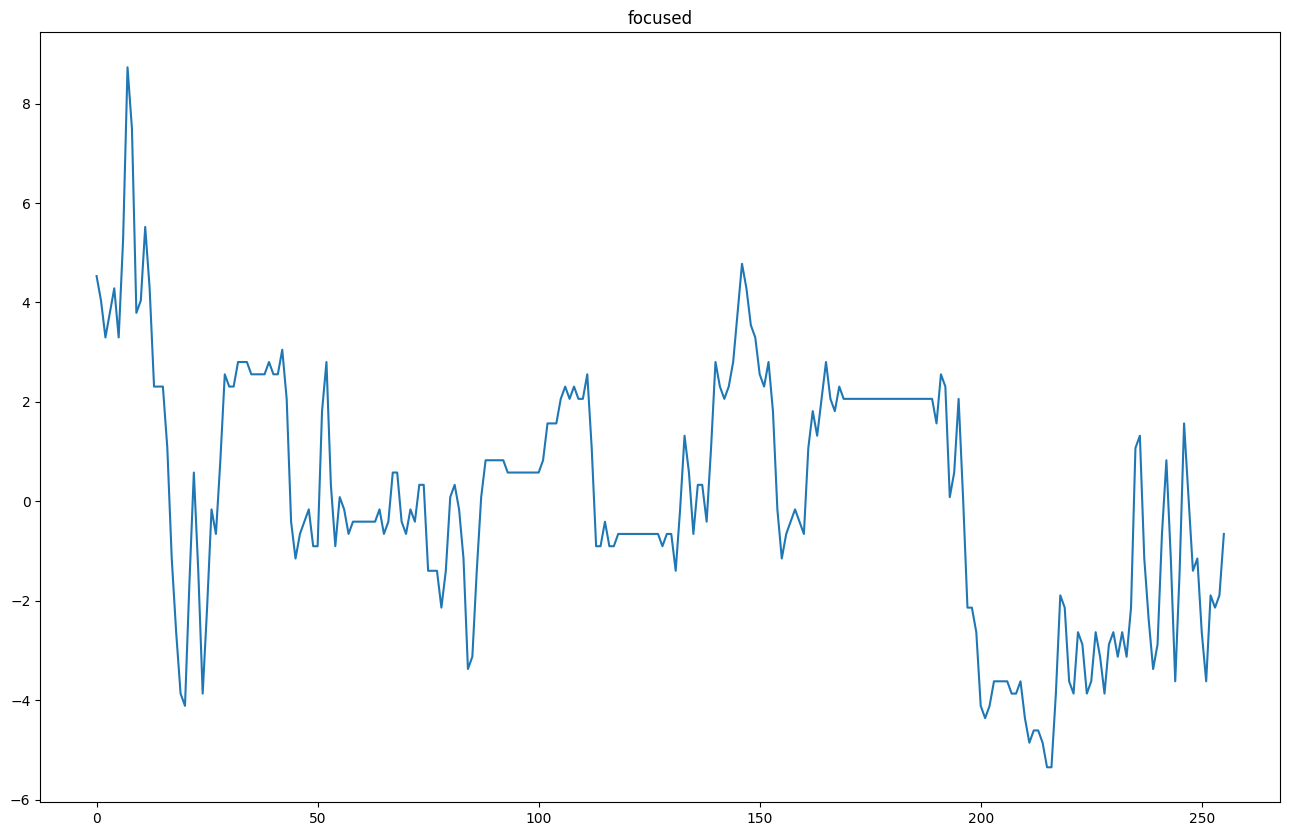

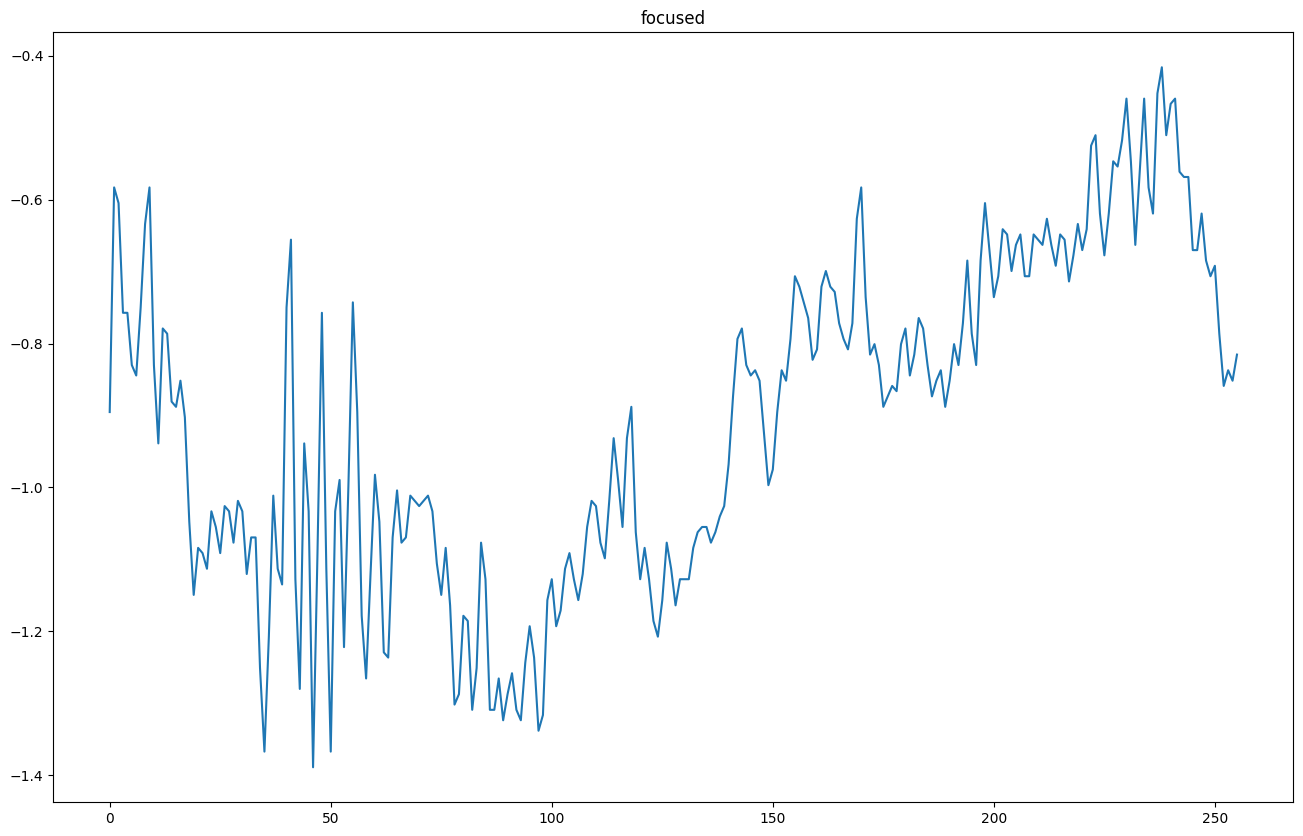

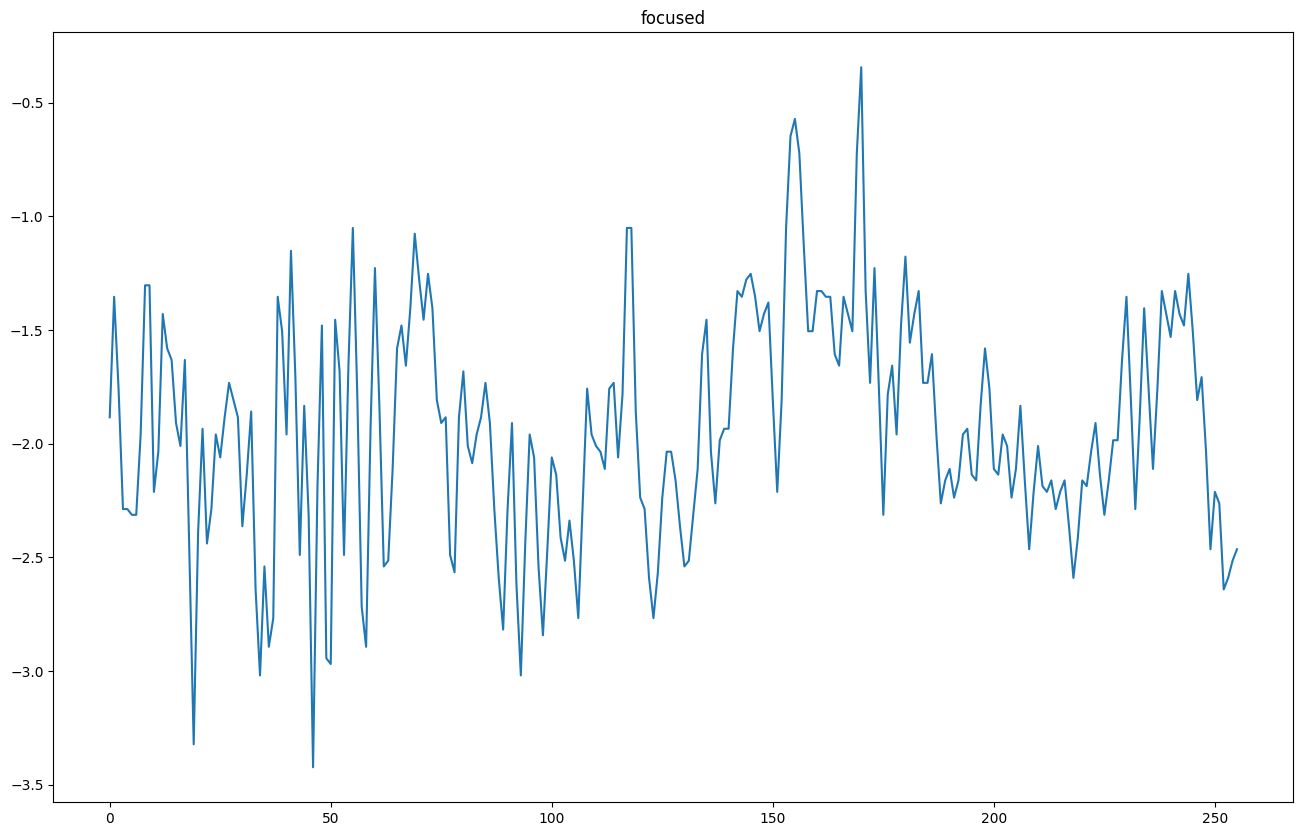

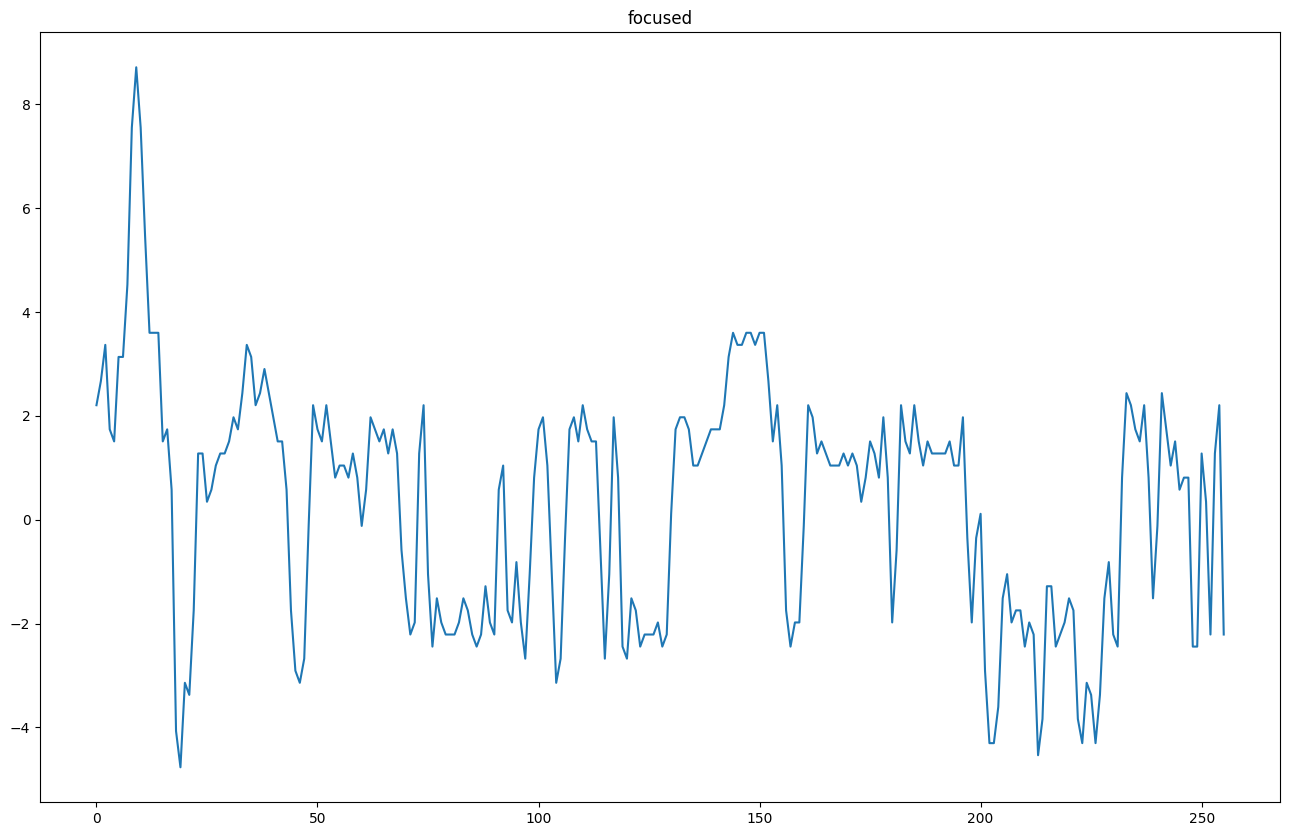

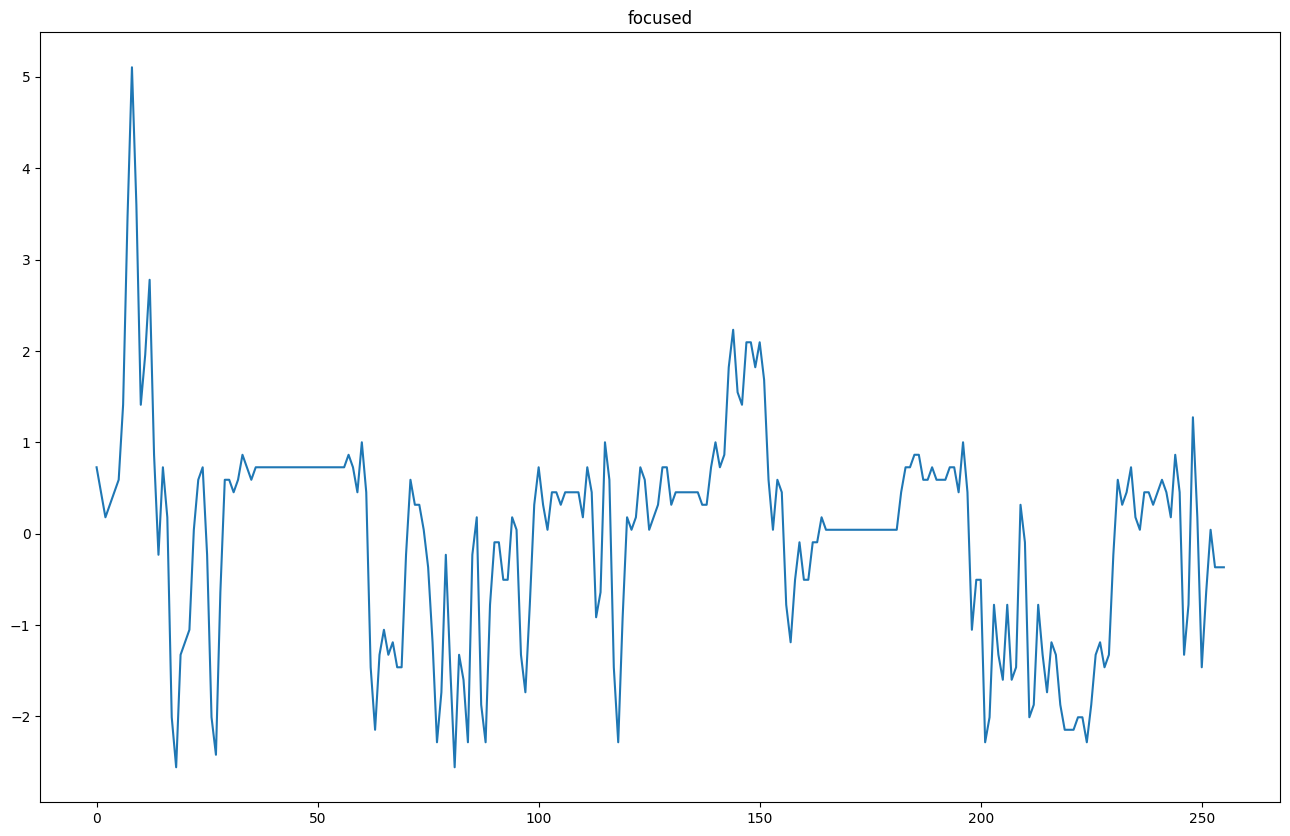

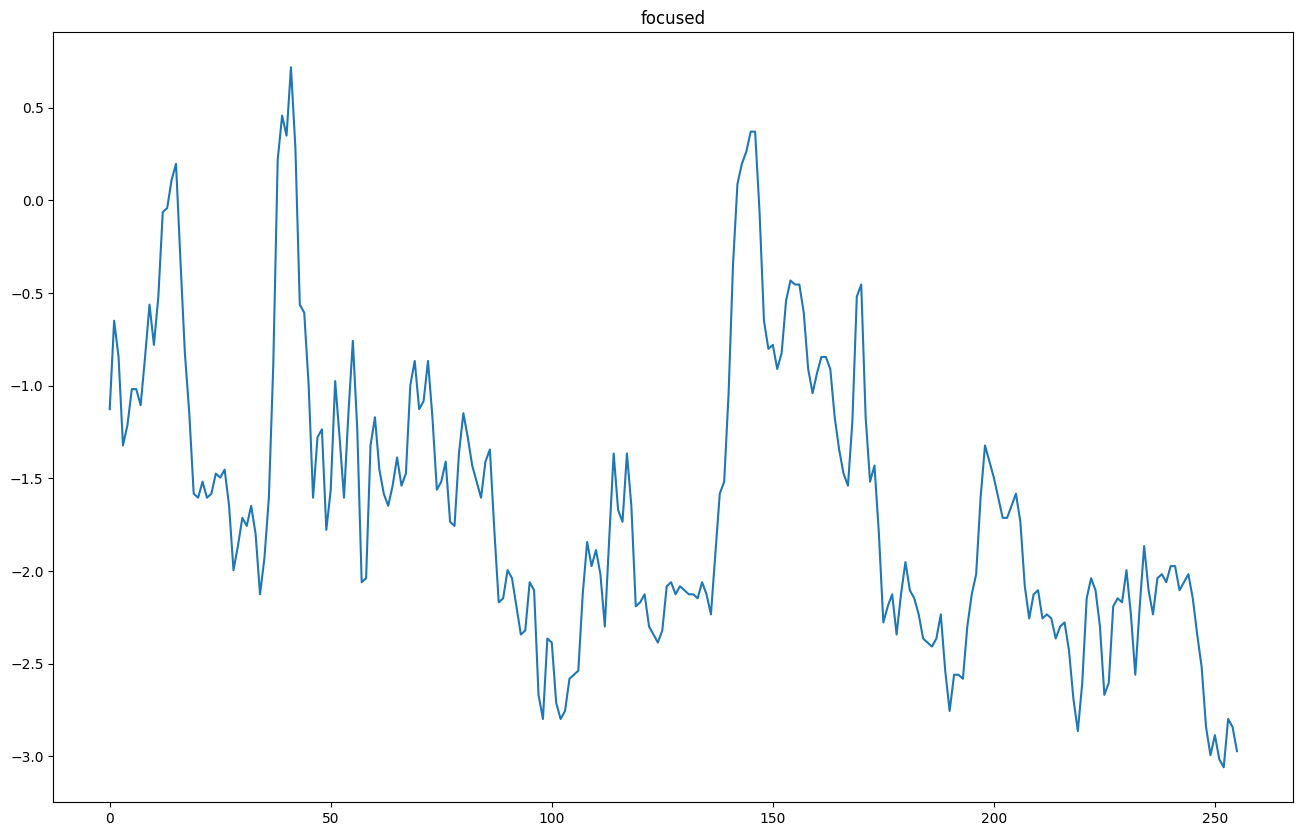

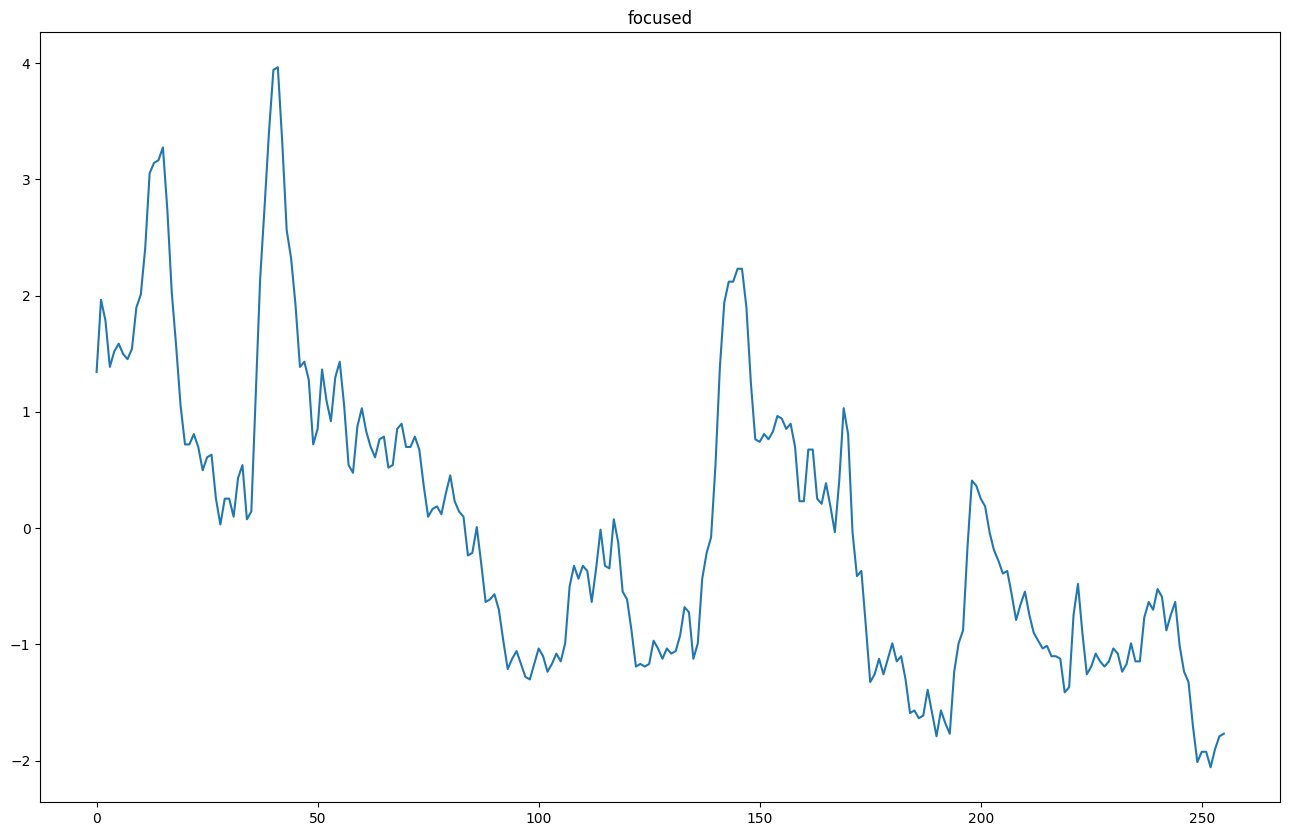

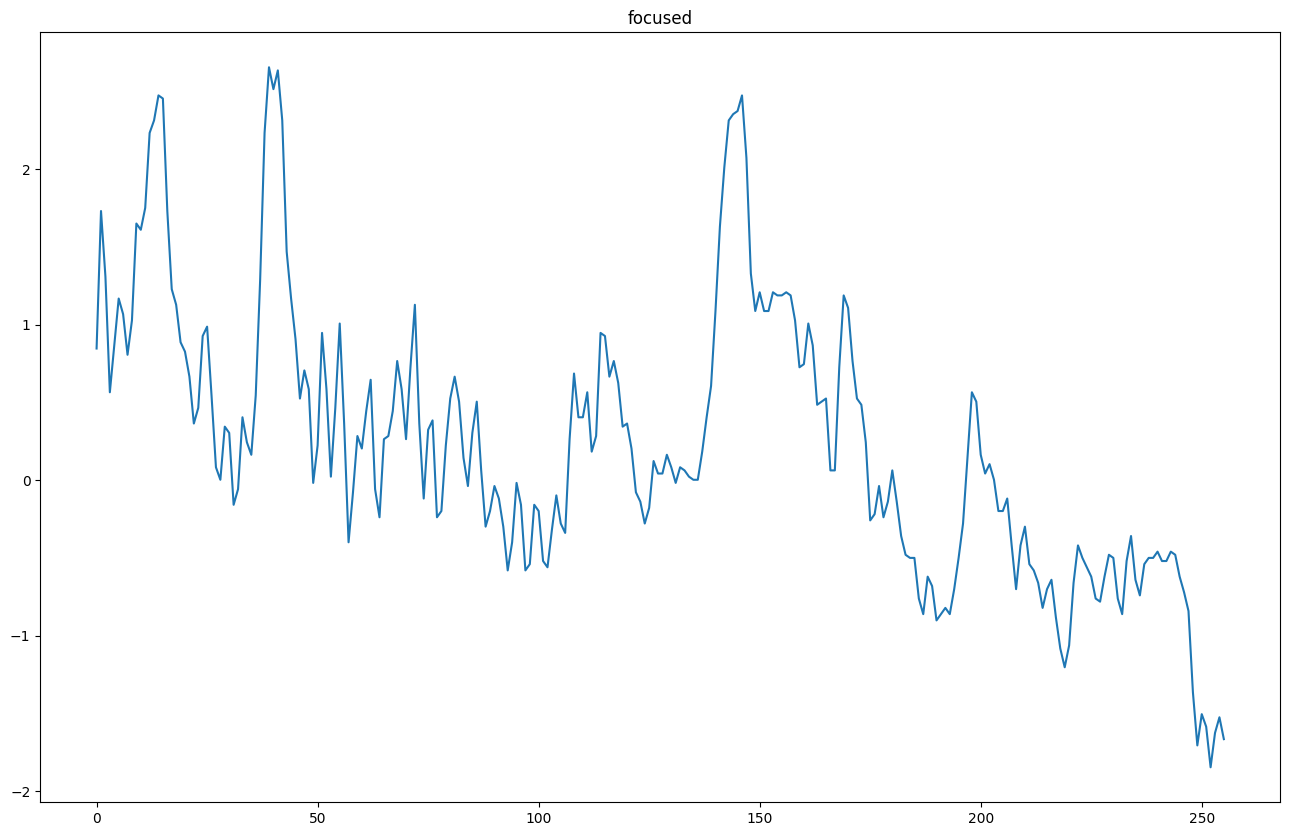

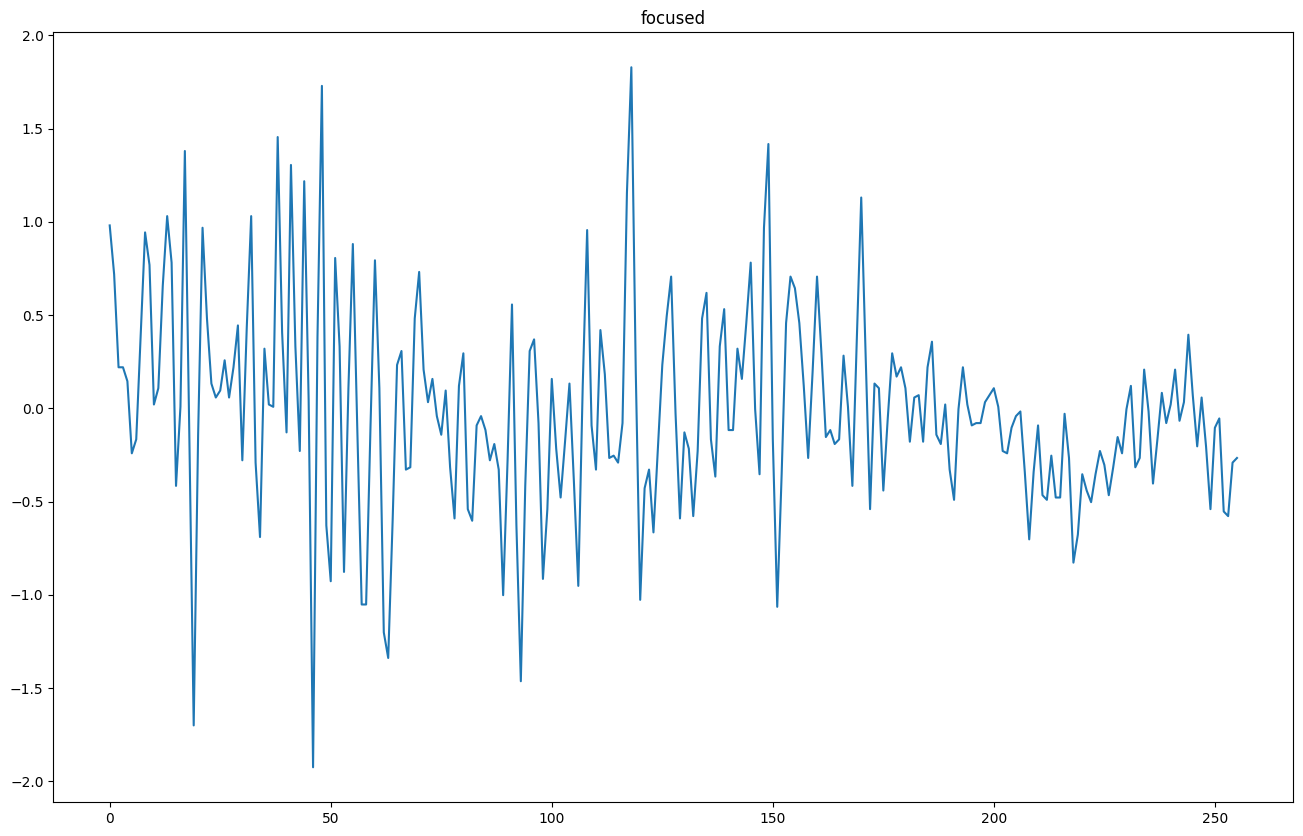

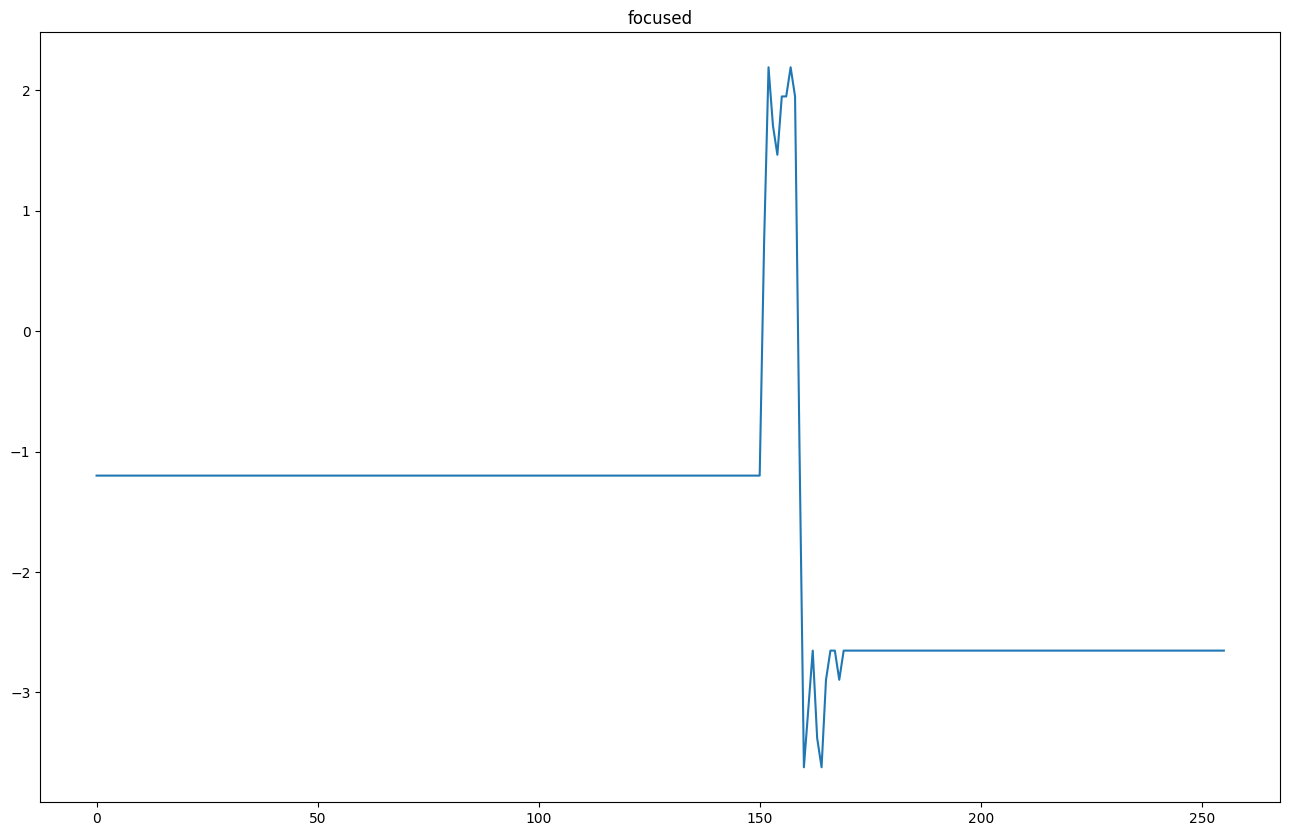

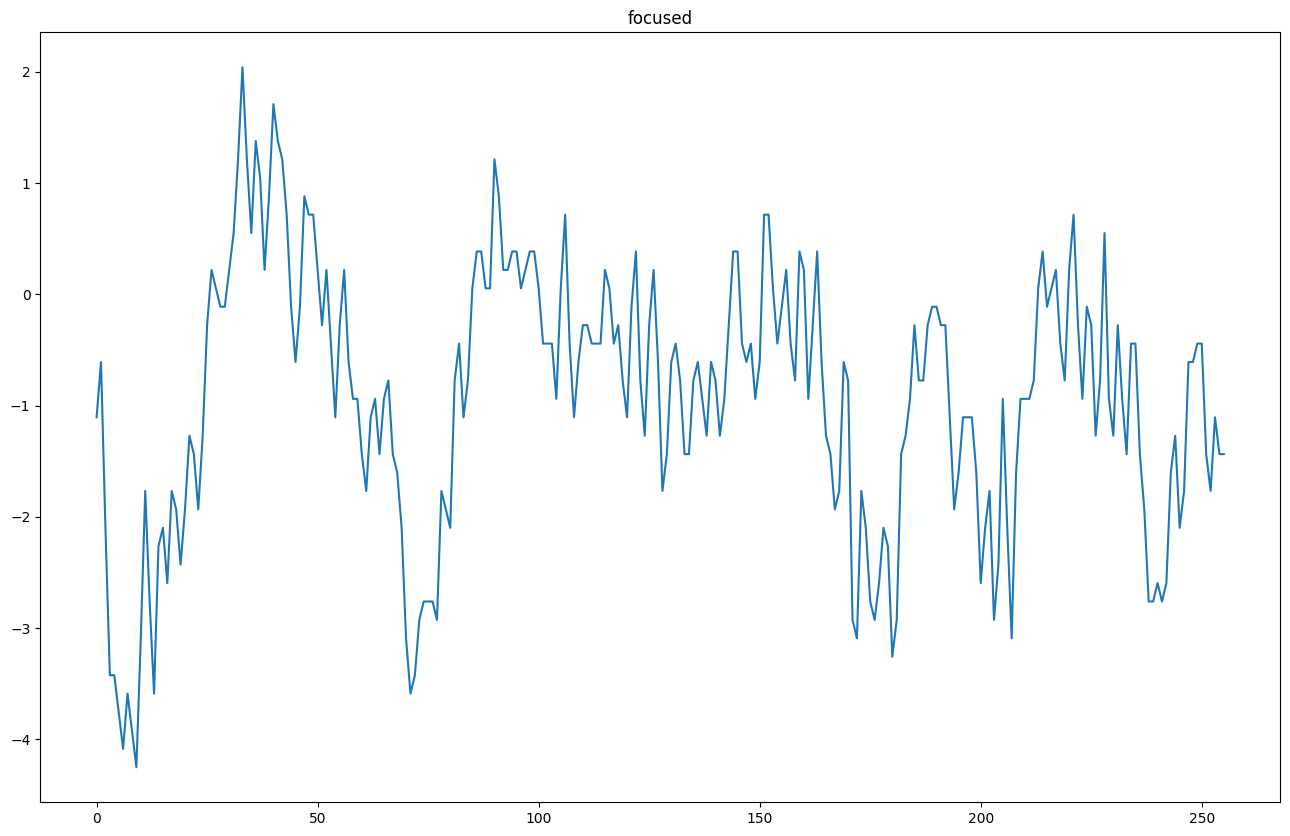

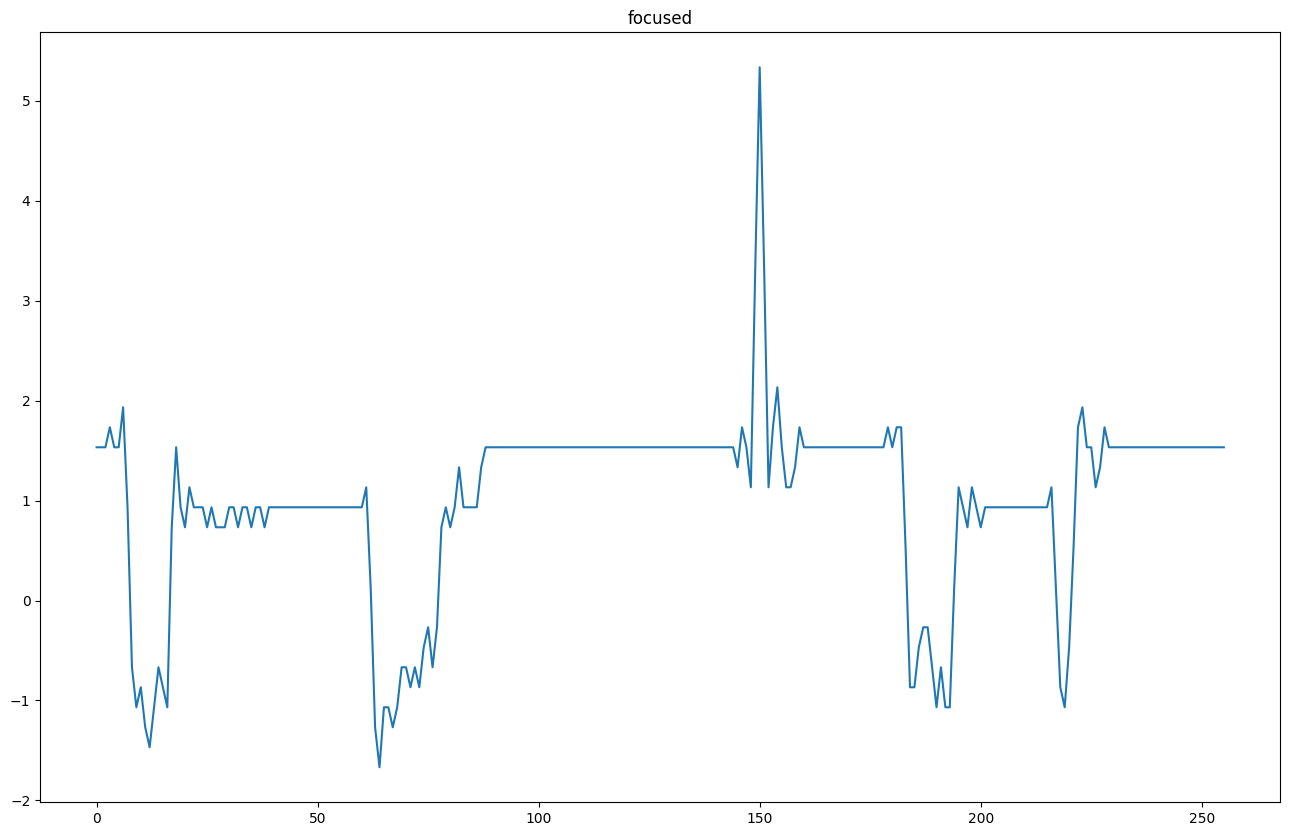

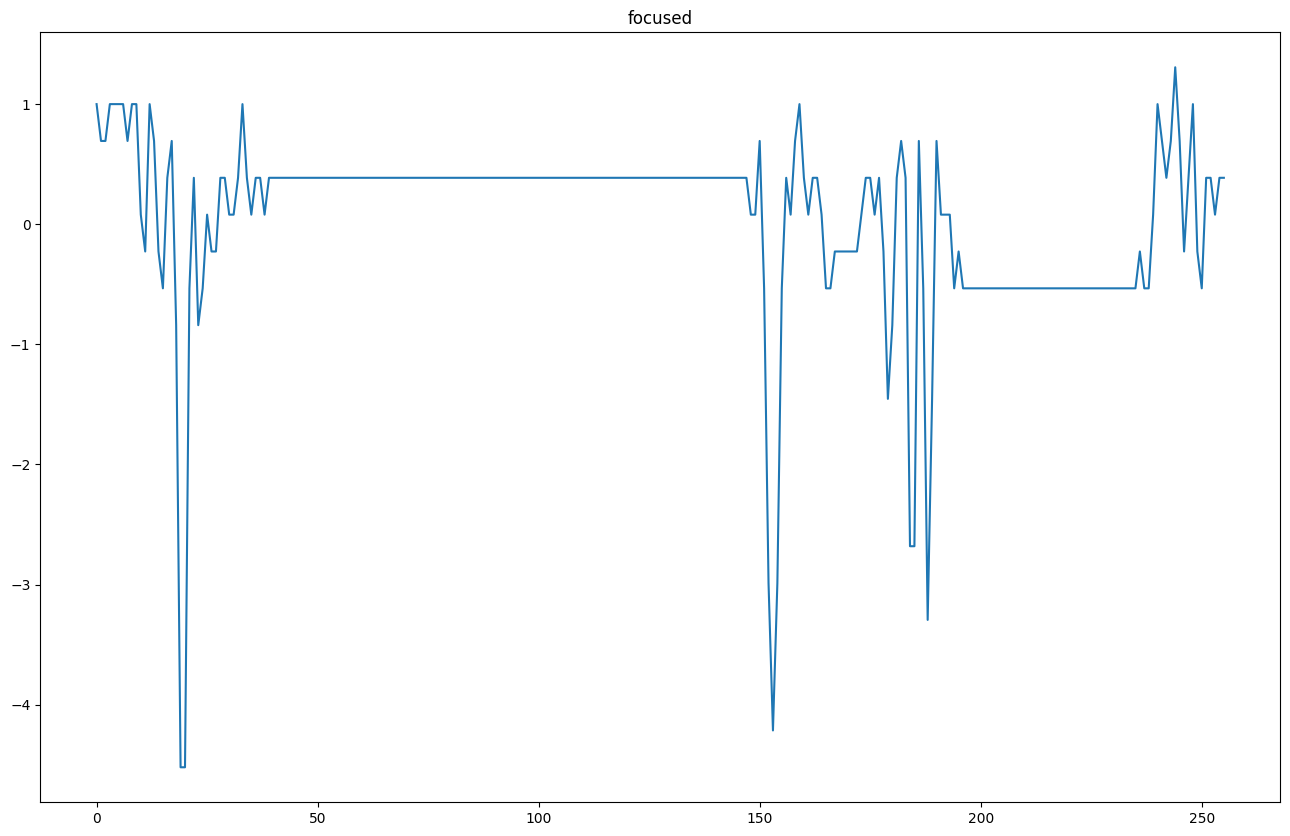

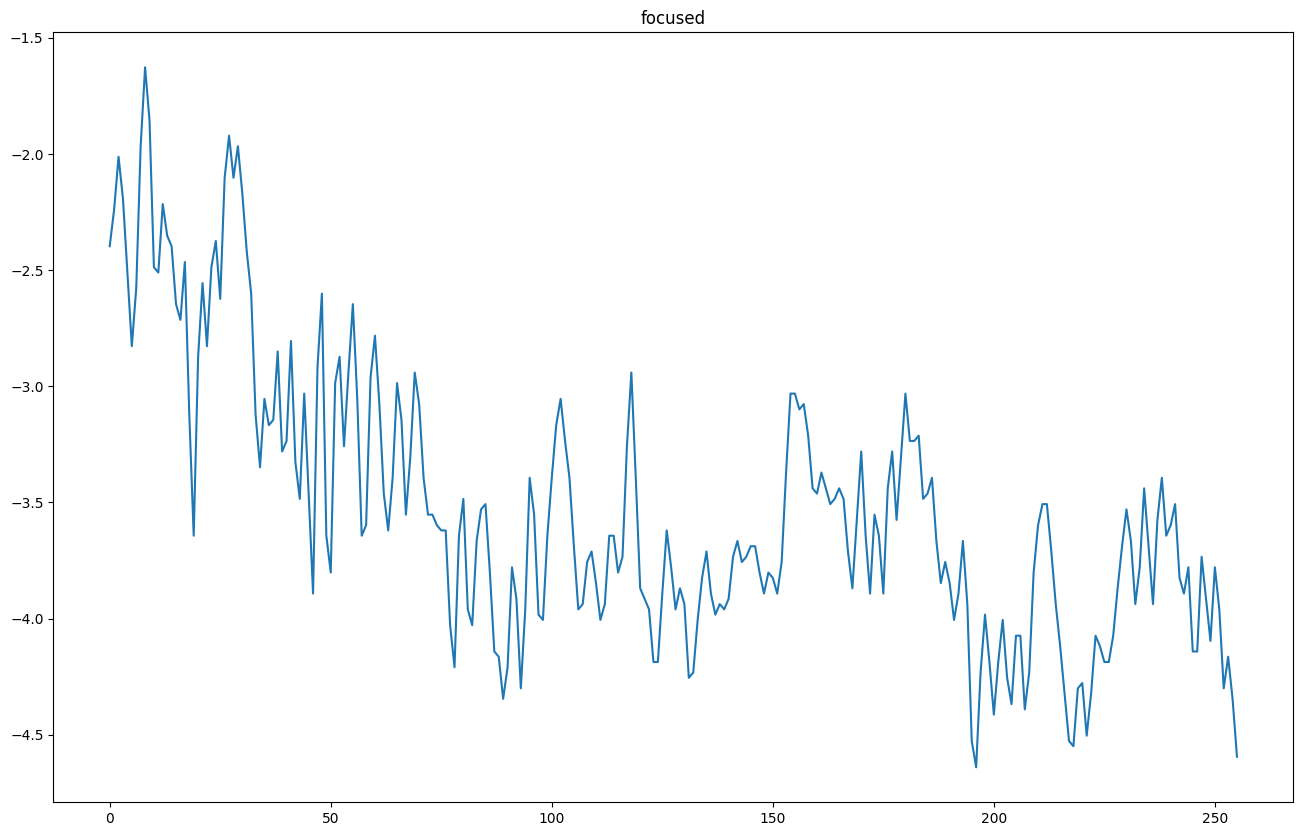

In [ ]:
state="focused"
plotleads(dataset.data[0], 14, state)

In [ ]:
train_size = int(0.8 * len(dataset))  # 80% cho training
val_size = int(0.1 * len(dataset))  # 10% cho validation
test_size = len(dataset) - train_size - val_size # 10% cho validation

# Chia dataset thành train và val
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Tạo DataLoader cho train và val
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
len(train_loader), len(val_loader), len(test_loader)

(5212, 652, 652)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create a bidirectional LSTM model class
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc1(out[:, -1, :]))
        out = F.relu(self.fc2(out))
        out = self.fc3(self.dropout(out))

        return out

    def predict(self, x):
        logits = self.forward(x)
        predict = F.softmax(logits, dim=1)
        predictions = torch.argmax(predict, dim=1)
        return predictions

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [ ]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 50
input_size = 14
num_layers = 2
hidden_size = 256
num_classes = 3

In [ ]:
# Initialize the custom network
bilstm = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstm.parameters(), lr=learning_rate)
early_stopping = EarlyStopping()

In [ ]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Train Network
def training(model, num_epochs):
    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_labels = []
        train_preds = []
        for data, targets in tqdm(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device).squeeze(1)
            targets = targets.to(device=device).long()

            # forward
            detections = model(data)
            loss = criterion(detections, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            # update running_loss
            running_loss += loss.item()

            # compute accuracy
            _, predicted = torch.max(detections, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Collect all labels and predictions for F1 score
            train_labels.extend(targets.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)
        f1 = f1_score(train_labels, train_preds, average='macro')

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        val_labels = []
        val_preds = []

        with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
            for batch_idx, (data, targets) in enumerate(val_loader):
                # Get data to cuda if possible
                data = data.to(device=device).squeeze(1)
                targets = targets.to(device=device).long()

                # forward
                detections = model(data)

                loss = criterion(detections, targets)

                # update running_loss
                running_loss += loss.item()

                # Đo lường độ chính xác
                _, predicted = torch.max(detections, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                # Collect all labels and predictions for F1 score
                val_labels.extend(targets.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

            epoch_loss = running_loss / len(val_loader)
            val_losses.append(epoch_loss)
            accuracy = 100 * correct / total
            val_accuracy.append(accuracy)
            f1 = f1_score(val_labels, val_preds, average='macro')

            print(f'Validation Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')

        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 0.001
num_epochs = 50
input_size = 14
num_layers = 2
hidden_size = 256
num_classes = 3

# Create a bidirectional LSTM model class
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc1(out[:, -1, :]))
        out = F.relu(self.fc2(out))
        out = self.fc3(self.dropout(out))

        return out

    def predict(self, x):
        logits = self.forward(x)
        predict = F.softmax(logits, dim=1)
        predictions = torch.argmax(predict, dim=1)
        return predictions

# Initialize the custom network
bilstm = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstm.parameters(), lr=learning_rate)
early_stopping = EarlyStopping()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Train Network
def training(model, num_epochs):
    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_labels = []
        train_preds = []
        for data, targets in tqdm(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device).squeeze(1)
            targets = targets.to(device=device).long()

            # forward
            detections = model(data)
            loss = criterion(detections, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            # update running_loss
            running_loss += loss.item()

            # compute accuracy
            _, predicted = torch.max(detections, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Collect all labels and predictions for F1 score
            train_labels.extend(targets.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)
        f1 = f1_score(train_labels, train_preds, average='macro')

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        val_labels = []
        val_preds = []

        with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
            for batch_idx, (data, targets) in enumerate(val_loader):
                # Get data to cuda if possible
                data = data.to(device=device).squeeze(1)
                targets = targets.to(device=device).long()

                # forward
                detections = model(data)

                loss = criterion(detections, targets)

                # update running_loss
                running_loss += loss.item()

                # Đo lường độ chính xác
                _, predicted = torch.max(detections, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                # Collect all labels and predictions for F1 score
                val_labels.extend(targets.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

            epoch_loss = running_loss / len(val_loader)
            val_losses.append(epoch_loss)
            accuracy = 100 * correct / total
            val_accuracy.append(accuracy)
            f1 = f1_score(val_labels, val_preds, average='macro')

            print(f'Validation Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')

        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

training(bilstm, num_epochs)

100%|██████████| 5212/5212 [02:32<00:00, 34.09it/s]


Epoch 1/50 - Train Loss: 0.78, Accuracy: 67.77%, F1 Score: 0.48
Validation Loss: 0.74, Accuracy: 68.11%, F1 Score: 0.47


100%|██████████| 5212/5212 [02:32<00:00, 34.21it/s]


Epoch 2/50 - Train Loss: 0.72, Accuracy: 70.29%, F1 Score: 0.52
Validation Loss: 0.67, Accuracy: 71.12%, F1 Score: 0.60


100%|██████████| 5212/5212 [02:31<00:00, 34.46it/s]


Epoch 3/50 - Train Loss: 0.63, Accuracy: 73.64%, F1 Score: 0.64
Validation Loss: 0.58, Accuracy: 77.03%, F1 Score: 0.69


100%|██████████| 5212/5212 [02:32<00:00, 34.23it/s]


Epoch 4/50 - Train Loss: 0.55, Accuracy: 76.56%, F1 Score: 0.69
Validation Loss: 0.50, Accuracy: 78.39%, F1 Score: 0.70


100%|██████████| 5212/5212 [02:31<00:00, 34.47it/s]


Epoch 5/50 - Train Loss: 0.49, Accuracy: 79.43%, F1 Score: 0.74
Validation Loss: 0.47, Accuracy: 80.20%, F1 Score: 0.76


100%|██████████| 5212/5212 [02:31<00:00, 34.40it/s]


Epoch 6/50 - Train Loss: 0.44, Accuracy: 81.62%, F1 Score: 0.77
Validation Loss: 0.43, Accuracy: 82.61%, F1 Score: 0.78


100%|██████████| 5212/5212 [02:31<00:00, 34.40it/s]


Epoch 7/50 - Train Loss: 0.39, Accuracy: 83.82%, F1 Score: 0.79
Validation Loss: 0.41, Accuracy: 83.21%, F1 Score: 0.79


100%|██████████| 5212/5212 [02:32<00:00, 34.20it/s]


Epoch 8/50 - Train Loss: 0.35, Accuracy: 85.75%, F1 Score: 0.82
Validation Loss: 0.39, Accuracy: 85.45%, F1 Score: 0.82


100%|██████████| 5212/5212 [02:33<00:00, 33.91it/s]


Epoch 9/50 - Train Loss: 0.32, Accuracy: 87.21%, F1 Score: 0.84
Validation Loss: 0.35, Accuracy: 86.72%, F1 Score: 0.83


100%|██████████| 5212/5212 [02:32<00:00, 34.18it/s]


Epoch 10/50 - Train Loss: 0.29, Accuracy: 88.35%, F1 Score: 0.85
Validation Loss: 0.37, Accuracy: 85.99%, F1 Score: 0.82


100%|██████████| 5212/5212 [02:32<00:00, 34.19it/s]


Epoch 11/50 - Train Loss: 0.26, Accuracy: 89.77%, F1 Score: 0.87
Validation Loss: 0.36, Accuracy: 86.82%, F1 Score: 0.83


100%|██████████| 5212/5212 [02:32<00:00, 34.10it/s]


Epoch 12/50 - Train Loss: 0.24, Accuracy: 90.70%, F1 Score: 0.88
Validation Loss: 0.35, Accuracy: 87.01%, F1 Score: 0.84


100%|██████████| 5212/5212 [02:32<00:00, 34.16it/s]


Epoch 13/50 - Train Loss: 0.22, Accuracy: 91.58%, F1 Score: 0.89
Validation Loss: 0.36, Accuracy: 87.35%, F1 Score: 0.84


100%|██████████| 5212/5212 [02:33<00:00, 34.06it/s]


Epoch 14/50 - Train Loss: 0.20, Accuracy: 92.20%, F1 Score: 0.90
Validation Loss: 0.35, Accuracy: 87.30%, F1 Score: 0.84


100%|██████████| 5212/5212 [02:31<00:00, 34.34it/s]


Epoch 15/50 - Train Loss: 0.18, Accuracy: 93.14%, F1 Score: 0.91
Validation Loss: 0.38, Accuracy: 87.14%, F1 Score: 0.84


100%|██████████| 5212/5212 [02:31<00:00, 34.33it/s]


Epoch 16/50 - Train Loss: 0.16, Accuracy: 93.74%, F1 Score: 0.92
Validation Loss: 0.36, Accuracy: 87.89%, F1 Score: 0.85


100%|██████████| 5212/5212 [02:31<00:00, 34.43it/s]


Epoch 17/50 - Train Loss: 0.15, Accuracy: 94.50%, F1 Score: 0.93
Validation Loss: 0.38, Accuracy: 88.10%, F1 Score: 0.85
Early stopping


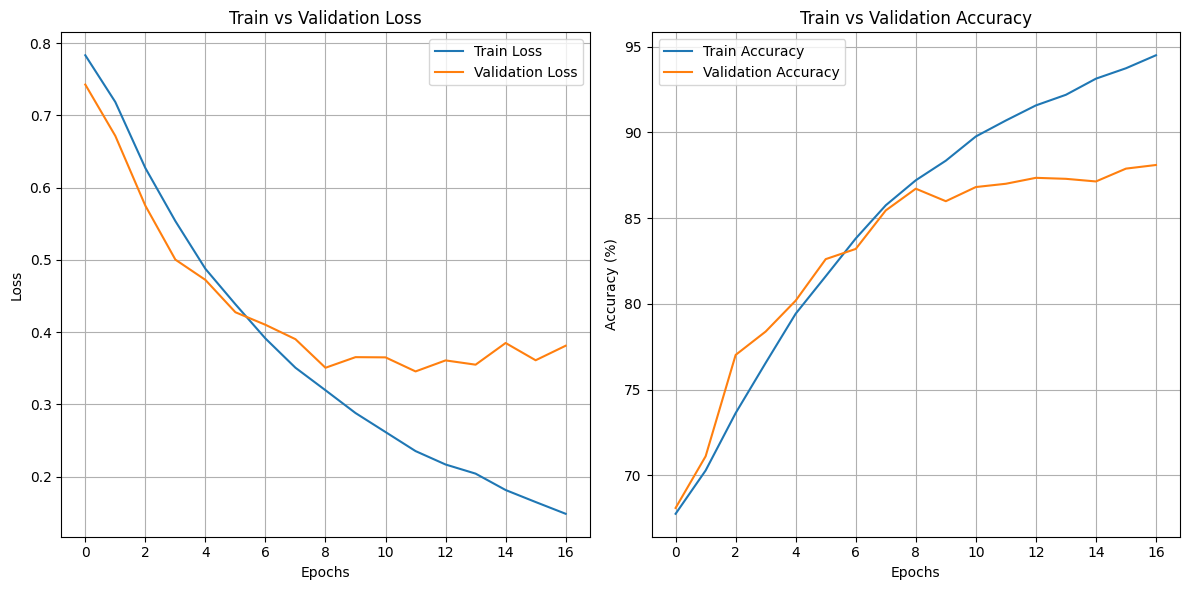

In [ ]:
# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
bilstm.eval()  # Đặt mô hình ở chế độ đánh giá
running_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
    for batch_idx, (data, targets) in enumerate(test_loader):
        # Get data to cuda if possible
        data = data.to(device).squeeze(1)
        targets = targets.to(device).long()

        # Forward
        detections = bilstm(data)

        # Tính Loss
        loss = criterion(detections, targets)
        running_loss += loss.item()

        # Tính Accuracy
        _, predicted = torch.max(detections, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Lưu các giá trị dự đoán và nhãn thực tế
        all_labels.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Tính Loss và Accuracy
loss = running_loss / len(test_loader)
accuracy = 100 * correct / total

# Tính F1 Score, Precision, và Recall
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# In ra kết quả
print(f"Test Results - Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Test Results - Loss: 0.3846, Accuracy: 87.90%
F1 Score: 0.85, Precision: 0.85, Recall: 0.84


In [ ]:
# Create a bidirectional LSTM model class
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, num_classes, dropout):
        super(CNN_BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # CNN layers
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, stride=1, padding=1)  # Output: (B, 64, sequence_length)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1) # Output: (B, 128, sequence_length)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # LSTM layers
        # cnn_output_size = sequence_length // 2  # Adjusted for max poolin
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.pool(x)

        x = x.permute(0, 2, 1)
        # x = x.reshape(x.size(0), -1, 128 * (x.size(1)))

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.dropout(self.fc1(out[:, -1, :])))
        out = self.fc2(self.dropout(out))

        return out

In [ ]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 30
input_size = 14
sequence_length = 256
num_layers = 2
hidden_size = 256
num_classes = 3
dropout = 0.5
# weight_decay = 1e-4

In [ ]:
# Initialize the custom network
cnn_bilstm = CNN_BiLSTM(input_size, hidden_size, sequence_length, num_layers, num_classes, dropout).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_bilstm.parameters(), lr=learning_rate)
early_stopping = EarlyStopping()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

In [ ]:
training(cnn_bilstm, num_epochs)

100%|██████████| 5212/5212 [01:38<00:00, 52.81it/s]


Epoch 1/30 - Train Loss: 0.74, Accuracy: 69.36%, F1 Score: 0.54
Validation Loss: 0.62, Accuracy: 74.13%, F1 Score: 0.64


100%|██████████| 5212/5212 [01:38<00:00, 52.87it/s]


Epoch 2/30 - Train Loss: 0.67, Accuracy: 71.50%, F1 Score: 0.60
Validation Loss: 0.55, Accuracy: 74.88%, F1 Score: 0.64


100%|██████████| 5212/5212 [01:38<00:00, 52.74it/s]


Epoch 3/30 - Train Loss: 0.59, Accuracy: 74.44%, F1 Score: 0.66
Validation Loss: 0.50, Accuracy: 78.97%, F1 Score: 0.72


100%|██████████| 5212/5212 [01:38<00:00, 53.05it/s]


Epoch 4/30 - Train Loss: 0.55, Accuracy: 76.48%, F1 Score: 0.69
Validation Loss: 0.47, Accuracy: 80.69%, F1 Score: 0.74


100%|██████████| 5212/5212 [01:39<00:00, 52.52it/s]


Epoch 5/30 - Train Loss: 0.50, Accuracy: 78.48%, F1 Score: 0.72
Validation Loss: 0.45, Accuracy: 81.10%, F1 Score: 0.76


100%|██████████| 5212/5212 [01:39<00:00, 52.52it/s]


Epoch 6/30 - Train Loss: 0.46, Accuracy: 80.21%, F1 Score: 0.74
Validation Loss: 0.64, Accuracy: 79.58%, F1 Score: 0.72


100%|██████████| 5212/5212 [01:39<00:00, 52.14it/s]


Epoch 7/30 - Train Loss: 0.44, Accuracy: 81.53%, F1 Score: 0.76
Validation Loss: 0.40, Accuracy: 84.15%, F1 Score: 0.80


100%|██████████| 5212/5212 [01:39<00:00, 52.13it/s]


Epoch 8/30 - Train Loss: 0.42, Accuracy: 82.45%, F1 Score: 0.77


In [ ]:
# Vẽ đồ thị loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Vẽ đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

In [ ]:
cnn_bilstm.eval()  # Đặt mô hình ở chế độ đánh giá
running_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
    for batch_idx, (data, targets) in enumerate(test_loader):
        # Get data to cuda if possible
        data = data.to(device).squeeze(1)
        targets = targets.to(device).long()

        # Forward
        detections = cnn_bilstm(data)

        # Tính Loss
        loss = criterion(detections, targets)
        running_loss += loss.item()

        # Tính Accuracy
        _, predicted = torch.max(detections, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Lưu các giá trị dự đoán và nhãn thực tế
        all_labels.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Tính Loss và Accuracy
loss = running_loss / len(test_loader)
accuracy = 100 * correct / total

# Tính F1 Score, Precision, và Recall
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# In ra kết quả
print(f"Test Results - Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

# Save the trained model
torch.save(cnn_bilstm.state_dict(), 'cnn_bilstm_model.pth')
print("Model saved as cnn_bilstm_model.pth")

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as scaler.pkl")
